In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly

# Vol. 3. Model deployment and blast movement simulation demo

## Redefine key functions

Certain functions from **Vol.1** need to be redefined in order to read blast panel data .xlsx files, convert them and clean them into a dataframe format. These functions have the following features:
- Clean blast panels
- Add Voronoi volume to each drillhole
- Get blast panel elevation based on an arbitrary monitoring location
- Calculate the total explosive mass in proximity to an arbitrary montioring location
- Estimate ideal movement direction for an arbitrary monitoring location

In [2]:
def clean_panels(f_bp_df):
    '''
    Cleans blast panel excel files and returns clean DataFrame
    '''
    bp_column_names = [
    'dh_num',
    'east',
    'north',
    'elev',
    'dh_d',
    'incl',
    'burden',
    'spacing',
    'dh_len_pr',
    'expl_len_pr',
    'stem_len_pr',
    'expl_mass_pr',
    'booster_qty_pr',
    'total_expl_mass_pr',
    'ms_delay',
    'cumul_ms_delay'
    ]
    
    f_bp_df = f_bp_df.iloc[:, :16] # Get first 16 columns with necessary blast panel data
    f_bp_df.columns = bp_column_names
    f_bp_df = f_bp_df.dropna().reset_index(drop=True)
    
    return f_bp_df

In [3]:
import geopandas as gpd
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import polygonize

def get_voronoi_vol_with_points(f_bp_df, bp_boundary_df):
    """
    Calculate Voronoi volumes for all points within the boundary specified by another DataFrame
    and return the coordinates of Voronoi vertices inside the boundary.
    """
    # Step 1: Create the boundary polygon
    bp_boundary_polygon = Polygon(zip(bp_boundary_df['east'], bp_boundary_df['north']))
    boundary_buffer = bp_boundary_polygon.buffer(50)
    boundary_coords = np.array(boundary_buffer.exterior.coords)

    # Step 2: Combine data points and boundary points
    coords = f_bp_df[['east', 'north']].values
    all_coords = np.vstack([coords, boundary_coords])

    # Step 3: Compute Voronoi diagram
    vor = Voronoi(all_coords)
    lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
    voronoi_polygons = list(polygonize(lines))

    # Step 4: Clip Voronoi polygons with the boundary
    voronois = gpd.GeoDataFrame(geometry=voronoi_polygons, crs="epsg:32633")
    boundary_gdf = gpd.GeoDataFrame(geometry=[bp_boundary_polygon], crs="epsg:32633")
    clipped_voronois = gpd.overlay(voronois, boundary_gdf, how="intersection")

    # Step 5: Extract Voronoi vertices inside the boundary
    voronoi_points = []
    for vertex in vor.vertices:
        point = Point(vertex)
        if bp_boundary_polygon.contains(point):
            voronoi_points.append([vertex[0], vertex[1]])

    # Step 6: Assign volumes to data points
    f_bp_df['voronoi_vol'] = 0.0
    spatial_index = clipped_voronois.sindex

    for idx, row in f_bp_df.iterrows():
        point = Point(row['east'], row['north'])
        possible_matches_index = list(spatial_index.intersection(point.bounds))
        possible_matches = clipped_voronois.iloc[possible_matches_index]
        for poly in possible_matches.geometry:
            if poly.contains(point):
                f_bp_df.at[idx, 'voronoi_vol'] = poly.area * row['bp_h']
                break  # Move to the next point once a match is found

    return f_bp_df, voronoi_points

In [4]:
from scipy.interpolate import griddata

def get_bp_elevation(f_bp_df, loc_df):
    """
    Calculate blast panel elevation at arbitrary locations.
    """
    # Extract coordinates and elevation values
    x = f_bp_df['east'].values
    y = f_bp_df['north'].values
    z = f_bp_df['elev'].values

    # Generate a meshgrid for the interpolation surface
    grid_x, grid_y = np.meshgrid(
        np.linspace(min(x), max(x), num=200),  # Adjust num for resolution
        np.linspace(min(y), max(y), num=200)
    )

    # Interpolate elevation values for the grid
    grid_z = griddata((x, y), z, (grid_x, grid_y), method="linear")

    # Interpolate elevation at all locations in loc_df
    locations = loc_df[['east', 'north']].values
    elevation_values = griddata(
        (grid_x.ravel(), grid_y.ravel()),
        grid_z.ravel(),
        locations,
        method="linear"
    )
    
    return elevation_values

In [5]:
def get_loc_pf(f_bp_df, loc_df, loc_radius=4.75):
    '''
    Calculate total explosive mass for each location in loc_df within a specified radius.
    '''
    loc_pf_array = []

    for _, loc in loc_df.iterrows():
        # Extract location coordinates
        loc_east, loc_north = loc['east'], loc['north']
        
        # Calculate distances
        delta_x = f_bp_df['east'].values - loc_east
        delta_y = f_bp_df['north'].values - loc_north    
        distances = (delta_x**2 + delta_y**2)**0.5

        # Identify points within the radius
        within_radius = distances <= loc_radius
        
        # Sum explosive mass amd Voronoi volume values for the points within the radius
        expl_mass_sum = f_bp_df.loc[within_radius, 'expl_mass_pr'].sum()
        voronoi_vol_sum = f_bp_df.loc[within_radius, 'voronoi_vol'].sum()

        # Estimate local powder factor
        if voronoi_vol_sum > 0:
            loc_pf = expl_mass_sum / voronoi_vol_sum
            loc_pf_array.append(loc_pf)
        else:
            loc_pf_array.append(np.nan)

    loc_pf_array = np.array(loc_pf_array)

    return loc_pf_array

In [6]:
def get_ideal_dir(f_bp_df, loc_df):
    """
    Calculate the ideal movement direction of an arbitrary location on the blast panel.
    """
    # Extract coordinates and delay values
    x = f_bp_df['east'].values
    y = f_bp_df['north'].values
    z = f_bp_df['ms_delay'].values

    # Generate a meshgrid for the delay surface
    meshgrid_x, meshgrid_y = np.meshgrid(
        np.linspace(x.min(), x.max(), num=500),
        np.linspace(y.min(), y.max(), num=500)
    )

    # Calculate the delay surface (z values) using interpolation
    meshgrid_z = griddata((x, y), z, (meshgrid_x, meshgrid_y), method="linear")

    # Compute spatial step sizes
    delta_x = meshgrid_x[0, 1] - meshgrid_x[0, 0]
    delta_y = meshgrid_y[1, 0] - meshgrid_y[0, 0]

    # Calculate the gradients of the delay surface
    gradient_x = np.gradient(meshgrid_z, axis=1) / delta_x
    gradient_y = np.gradient(meshgrid_z, axis=0) / delta_y

    # Prepare meshgrid points for efficient interpolation
    meshgrid_pts = np.column_stack((meshgrid_x.ravel(), meshgrid_y.ravel()))
    gradient_x_flat = gradient_x.ravel()
    gradient_y_flat = gradient_y.ravel()

    # Interpolate gradients for all points in loc_df at once
    loc_points = loc_df[['east', 'north']].values
    loc_gradient_x = griddata(meshgrid_pts, gradient_x_flat, loc_points, method="linear")
    loc_gradient_y = griddata(meshgrid_pts, gradient_y_flat, loc_points, method="linear")

    # Compute magnitudes and normalize the gradients
    gradient_magnitudes = np.hypot(loc_gradient_x, loc_gradient_y)
    # Avoid division by zero
    gradient_magnitudes[gradient_magnitudes == 0] = np.nan  # Mark invalid gradients

    loc_vector_x = loc_gradient_x / gradient_magnitudes
    loc_vector_y = loc_gradient_y / gradient_magnitudes

    # Compute azimuth angles (degrees, normalized to [0, 360))
    loc_ideal_dir_rad = np.arctan2(-loc_vector_x, -loc_vector_y)
    loc_ideal_dir_deg = (np.degrees(loc_ideal_dir_rad) + 360) % 360

    return loc_ideal_dir_deg

And addition function was defined so as to select random locations within all possible monitoring location within the blast panel boudnary. This is performed for the purpose of sampling blast movement vectors in random grid with an arbitrary density, defined by a radius. For the sake of respecting the osberved blasting conditions, based on which the regressors are built on, an offset value is introduced so as to sample movement locations within an offset of the boudnary within the panel.

In [7]:
def select_rand_locations_within_boundary(df, polygon_df, radius=5, offset=6, random_seed=42):
    """
    Selects points that no two points are within the given radius,
    and a point is only considered if it lies within the offset of a boundary polygon.
    """
    # Convert the polygon DataFrame to a shapely Polygon
    polygon_coords = list(zip(polygon_df['east'], polygon_df['north']))
    polygon = Polygon(polygon_coords)
    
    # Create an offset polygon
    offset_polygon = polygon.buffer(-offset)
    
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    selected_rows = []

    # Iterate through the shuffled DataFrame
    for _, row in shuffled_df.iterrows():
        point = Point(row['east'], row['north'])
        # Check if the point is within the offset polygon
        if offset_polygon.contains(point):
            # Check if the point is sufficiently far from all selected points
            if all(np.sqrt((row['east'] - selected_row['east'])**2 + 
                           (row['north'] - selected_row['north'])**2) >= radius
                   for selected_row in selected_rows):
                selected_rows.append(row)
    
    # Create a new DataFrame from selected rows
    selected_df = pd.DataFrame(selected_rows)
    return selected_df

In [8]:
def quantile_loss_ml(y_true, y_pred, quantile=0.5):
    diff = y_true - y_pred
    return np.mean(np.maximum(quantile * diff, (1 - quantile) * -diff))

## Reading blast panel data

Here one can write the initial conditiosn of a blast, including the following features:
- ID (or name) of the blast panel
- Planned explosive to be used
- Random seed number for overall simualtion (including regressor drawing, monitoring locations random sampling, monitor depth)
- Radius of monitoring locations density (m) - No two locations will be in a distance below the specified radius
- Blast panel boundary offset (m) - The offset distance within the blast panel boundary where the monitoring locations are samples

In [9]:
bp_name = "PB1_450_007"
expl_type = "ANFO"
M_RAND_SEED = 42
RADIUS = 5
OFFSET = 5

expl_gas_prod_dict = {
    'ANFO': 988,
    'Riogel': 933
}

In [10]:
bp = pd.read_excel(f"Demo panel/{bp_name}.xlsx", sheet_name = "panel")
bp = clean_panels(bp).reset_index(drop=True)
bp

,dh_num,east,north,elev,dh_d,incl,burden,spacing,dh_len_pr,expl_len_pr,stem_len_pr,expl_mass_pr,booster_qty_pr,total_expl_mass_pr,ms_delay,cumul_ms_delay
0,1.0,552.358,533.031,454.877,105,90,3.45,3,5.177,2.977,2.2,20.2436,1,20.6586,1767,2267
1,2.0,548.921,533.125,454.915,105,90,3.45,3,5.215,3.015,2.2,20.502,1,20.917,1675,2175
2,3.0,545.432,533.055,455.069,105,90,3.45,3,5.369,3.169,2.2,21.5492,1,21.9642,1583,2083
3,4.0,542,533.035,454.897,105,90,3.45,3,5.197,2.997,2.2,20.3796,1,20.7946,1491,1991
4,5.0,538.492,533.07,454.852,105,90,3.45,3,5.152,2.952,2.2,20.0736,1,20.4886,1399,1899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,203.0,542.565,488.002,454.968,105,90,3.45,3,5.268,3.068,2.2,20.8624,1,21.2774,1477,1977
203,204.0,546.059,487.835,454.99,105,90,3.45,3,5.29,3.09,2.2,21.012,1,21.427,1569,2069
204,205.0,549.562,487.681,454.996,105,90,3.45,3,5.296,3.096,2.2,21.0528,1,21.4678,1661,2161
205,206.0,553.215,487.277,455.019,105,90,3.45,3,5.319,3.119,2.2,21.2092,1,21.6242,1753,2253


Everything seems to be in place. Now we have to add the target surface elevation of the blast design, which would be visible once the blasted rock mass is excavated. It can be taken based on the blast panel name. It also serves as a value, which can be subtracted by the surface of the blast panel to determine the blast panel height. 

In [11]:
target_elevation = int(bp_name[4:7])
bp['bp_h'] = bp['elev'] - target_elevation
bp['bp_h'].head()

0    4.877
1    4.915
2    5.069
3    4.897
4    4.852
Name: bp_h, dtype: object

After that the blast panel boundary is loaded and its columns are renamed for the sake of simplicity and to avoid longs names.

In [12]:
bp_boundary = pd.read_excel(f"Demo panel/{bp_name}.xlsx", sheet_name = "boundary")
bp_boundary.columns = ['east', 'north']
bp_boundary.head()

,east,north
0,504.5450,486.5549
1,508.1053,486.5162
2,555.0000,486.0065
3,555.0000,535.5858
4,521.5630,535.7752


The Voronoi volumes are the estimated for each drillhole and are added to the blast panel dataframe as follows:

In [13]:
bp, voronoi_pts = get_voronoi_vol_with_points(bp, bp_boundary)

In [14]:
bp.head()

,dh_num,east,north,elev,dh_d,incl,burden,spacing,dh_len_pr,expl_len_pr,stem_len_pr,expl_mass_pr,booster_qty_pr,total_expl_mass_pr,ms_delay,cumul_ms_delay,bp_h,voronoi_vol
0,1.0,552.358,533.031,454.877,105,90,3.45,3,5.177,2.977,2.2,20.2436,1,20.6586,1767,2267,4.877,101.845803
1,2.0,548.921,533.125,454.915,105,90,3.45,3,5.215,3.015,2.2,20.502,1,20.917,1675,2175,4.915,68.149306
2,3.0,545.432,533.055,455.069,105,90,3.45,3,5.369,3.169,2.2,21.5492,1,21.9642,1583,2083,5.069,69.902647
3,4.0,542,533.035,454.897,105,90,3.45,3,5.197,2.997,2.2,20.3796,1,20.7946,1491,1991,4.897,68.429601
4,5.0,538.492,533.07,454.852,105,90,3.45,3,5.152,2.952,2.2,20.0736,1,20.4886,1399,1899,4.852,68.058680


In [15]:
bp.shape

(207, 18)

For this example there are 207 drillholes. Just in case, let's check for missing values and some incorrect estimations.

In [16]:
bp.isna().sum()

dh_num                0
east                  0
north                 0
elev                  0
dh_d                  0
incl                  0
burden                0
spacing               0
dh_len_pr             0
expl_len_pr           0
stem_len_pr           0
expl_mass_pr          0
booster_qty_pr        0
total_expl_mass_pr    0
ms_delay              0
cumul_ms_delay        0
bp_h                  0
voronoi_vol           0
dtype: int64

In [17]:
bp[bp['voronoi_vol']>=0].shape

(207, 18)

Evertything is in order. 

Now let's get all posible monitoring locations based on the Voronoi grid from the drillholes.

In [18]:
voronoi_pts = np.array(voronoi_pts)

All possible monitoring locations are placed in a new dataframe where will gradually blasting conditions columns and simulated values.

First let's start with the coordinates

In [19]:
df_raw = pd.DataFrame()
df_raw['east'] = voronoi_pts[:,0]
df_raw['north'] = voronoi_pts[:,1]

Then, let's add a random installation height within the range of 0.5 and 4.0 m from the target surface.

In [20]:
np.random.seed(M_RAND_SEED)
df_raw['inst_h'] = [np.random.randint(50, 400) / 100 for _ in range(len(df_raw))]

Then we estimate the elevation of each potential monitoring location.

In [21]:
df_raw['elev'] = target_elevation + df_raw['inst_h']

The we use the inerpolation function to estimate the height of the pre-blast panel above the potential monitoring location and the panel height.

In [22]:
df_raw['bp_elev'] = get_bp_elevation(bp, df_raw)
df_raw['bp_h'] = df_raw['bp_elev'] - target_elevation

After that, we estimate the the *Local poweder factor* and *Local gas products factor* for the assumed radius of 4.75 m.

In [23]:
df_raw['loc_pf'] = get_loc_pf(bp, df_raw, loc_radius=4.75)
df_raw['loc_gpf'] = df_raw['loc_pf'] * expl_gas_prod_dict[expl_type]

Then we estimate the idel movement direction by the negative gradient of the timing contours, corresponging to the sequence of blasting.

In [24]:
df_raw['ideal_dir'] = get_ideal_dir(bp, df_raw)

In [25]:
df_raw.head()

,east,north,inst_h,elev,bp_elev,bp_h,loc_pf,loc_gpf,ideal_dir
0,547.194936,532.171096,1.52,451.52,454.997571,4.997571,0.351123,346.909986,269.678020
1,516.062678,526.312043,3.98,453.98,454.307481,4.307481,0.395966,391.214210,258.704725
2,516.145773,528.765403,3.20,453.20,454.339820,4.339820,0.403243,398.404225,279.860947
3,522.924510,532.372732,1.56,451.56,455.084901,5.084901,0.371882,367.419166,269.163711
4,541.759778,523.057053,1.21,451.21,454.872247,4.872247,0.406394,401.517260,267.662252


In [26]:
df_raw.isna().sum()

east         0
north        0
inst_h       0
elev         0
bp_elev      7
bp_h         7
loc_pf       0
loc_gpf      0
ideal_dir    7
dtype: int64

Some edge cases may prove to be invalid, but they can be removed for the sake of the demo.

In [27]:
df_cleaned = df_raw.dropna().copy()
df_cleaned.head()

,east,north,inst_h,elev,bp_elev,bp_h,loc_pf,loc_gpf,ideal_dir
0,547.194936,532.171096,1.52,451.52,454.997571,4.997571,0.351123,346.909986,269.678020
1,516.062678,526.312043,3.98,453.98,454.307481,4.307481,0.395966,391.214210,258.704725
2,516.145773,528.765403,3.20,453.20,454.339820,4.339820,0.403243,398.404225,279.860947
3,522.924510,532.372732,1.56,451.56,455.084901,5.084901,0.371882,367.419166,269.163711
4,541.759778,523.057053,1.21,451.21,454.872247,4.872247,0.406394,401.517260,267.662252


## Blast movement demo

Based on the arbitrary radius for non-overlapping monitoring locations, a filtered dataframe can be established only for those random location which fall under the condition. 

In [28]:
df = select_rand_locations_within_boundary(df_cleaned, bp_boundary, radius=RADIUS, offset=OFFSET, random_seed=M_RAND_SEED)

A scatter plot of all possible montirong locations among all drillholes is plotted below. The filtered locations, based on which the prediction would be based are marked with a red 'X'. 

[]

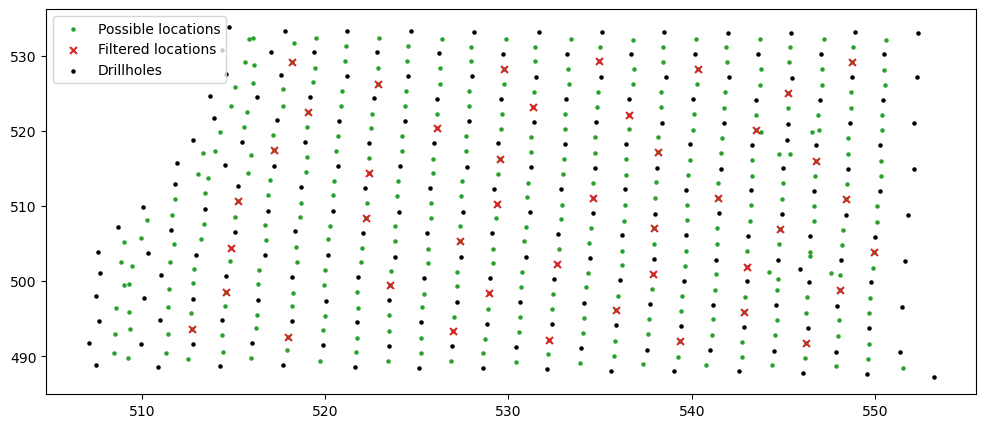

In [29]:
plt.figure(figsize=(12, 5))
plt.scatter(df_cleaned['east'], df_cleaned['north'], c='tab:green', s=5, label='Possible locations')
plt.scatter(df['east'], df['north'], c='tab:red', s=25, marker='x', label='Filtered locations')
plt.scatter(bp['east'], bp['north'], c='black', s=5, label='Drillholes')
plt.legend(loc='best')
plt.plot()

Now for the fun part. 

We have to load the created quantile regression models and input scalers to simulate a single realization of the blast movement phenomenon.

In [30]:
import os
import joblib
import pickle

In [31]:
target_names = ['m_h_ff', 'm_v', 'm_h_dev', 'det_depth']
model_folder = "New Models"

# Initialize dictionaries for each target
models_m_h_ff = {}
models_m_v = {}
models_m_h_dev = {}
models_det_depth = {}

# Loop through quantiles and load models into respective dictionaries
for q in np.arange(0.01, 1, 0.01):
    q = np.round(q, 2)  # Ensure quantile is rounded
    
    for target in target_names:
        # Define the target folder and model file path
        target_folder = os.path.join(model_folder, target)
        model_file = f"regressor_model_{target}_{q}.pkl"
        model_path = os.path.join(target_folder, model_file)
        
        # Ensure the target folder exists
        os.makedirs(target_folder, exist_ok=True)
        
        # Check if the file exists before loading
        if os.path.exists(model_path):
            loaded_model = joblib.load(model_path)
            
            # Assign models to the correct dictionary based on the target
            if target == 'm_h_ff':
                models_m_h_ff[q] = loaded_model
            elif target == 'm_v':
                models_m_v[q] = loaded_model
            elif target == 'm_h_dev':
                models_m_h_dev[q] = loaded_model
            elif target == 'det_depth':
                models_det_depth[q] = loaded_model
        else:
            print(f"Model file not found: {model_path}")

print("All models loaded.")

All models loaded.


In [32]:
# Initialize scalers for each target
x_scaler_m_h_ff = None
x_scaler_m_v = None
x_scaler_m_h_dev = None
x_scaler_det_depth = None

for target in target_names:
        # Define the target folder and scaler file path
        target_folder = os.path.join(model_folder, target)
        model_file = f"x_scaler_{target}.pkl"
        model_path = os.path.join(target_folder, model_file)
        
        # Ensure the target folder exists
        os.makedirs(target_folder, exist_ok=True)
        
        # Check if the file exists before loading
        if os.path.exists(model_path):
            loaded_model = joblib.load(model_path)
            
            # Assign scalers to the correct dictionary based on the target
            if target == 'm_h_ff':
                x_scaler_m_h_ff = loaded_model
            elif target == 'm_v':
                x_scaler_m_v = loaded_model
            elif target == 'm_h_dev':
                x_scaler_m_h_dev = loaded_model
            elif target == 'det_depth':
                x_scaler_det_depth = loaded_model
        else:
            print(f"Scaler file not found: {model_path}")

print("All scalers loaded.")

All scalers loaded.


### Predicting Horizontal free-face movement

All required new columns for the predicted blast movement features are added to the monitoring dataframe. For the sake of reproducability, all monitoring locations are simulated. After that the non-overlapping ones are randomly samples for the sake of predictions. This is done so as to reduce the possibility of introducing artifacts to the model.

In [33]:
df_cleaned['m_h_ff'] = np.nan
df_cleaned['m_v'] = np.nan
df_cleaned['m_h_dev'] = np.nan
df_cleaned['det_h'] = np.nan
df_cleaned['det_depth'] = np.nan

In [34]:
df_cleaned.head()

,east,north,inst_h,elev,bp_elev,bp_h,loc_pf,loc_gpf,ideal_dir,m_h_ff,m_v,m_h_dev,det_h,det_depth
0,547.194936,532.171096,1.52,451.52,454.997571,4.997571,0.351123,346.909986,269.678020,NaN,NaN,NaN,NaN,NaN
1,516.062678,526.312043,3.98,453.98,454.307481,4.307481,0.395966,391.214210,258.704725,NaN,NaN,NaN,NaN,NaN
2,516.145773,528.765403,3.20,453.20,454.339820,4.339820,0.403243,398.404225,279.860947,NaN,NaN,NaN,NaN,NaN
3,522.924510,532.372732,1.56,451.56,455.084901,5.084901,0.371882,367.419166,269.163711,NaN,NaN,NaN,NaN,NaN
4,541.759778,523.057053,1.21,451.21,454.872247,4.872247,0.406394,401.517260,267.662252,NaN,NaN,NaN,NaN,NaN


Following the logic of the chain regression models, first we need to estimate the movement towards the free face.

Using the predefined scalar, we scale the input features so as to get correct results from the model.

In [35]:
X_m_h_ff = x_scaler_m_h_ff.transform(df_cleaned[['inst_h', 'loc_gpf']].values)

D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


A random regressor is drawn from the bag...

In [36]:
np.random.seed(M_RAND_SEED+1)
m_h_ff_pred = []

for i in range(len(df_cleaned)):
    cur_pred = models_m_h_ff[np.random.randint(1, 99) / 100].predict(X_m_h_ff)
    m_h_ff_pred.append(cur_pred)

m_h_ff_pred = m_h_ff_pred[0]

In [37]:
df_cleaned['m_h_ff'] = m_h_ff_pred
df_cleaned.head()

,east,north,inst_h,elev,bp_elev,bp_h,loc_pf,loc_gpf,ideal_dir,m_h_ff,m_v,m_h_dev,det_h,det_depth
0,547.194936,532.171096,1.52,451.52,454.997571,4.997571,0.351123,346.909986,269.678020,0.991928,NaN,NaN,NaN,NaN
1,516.062678,526.312043,3.98,453.98,454.307481,4.307481,0.395966,391.214210,258.704725,1.512562,NaN,NaN,NaN,NaN
2,516.145773,528.765403,3.20,453.20,454.339820,4.339820,0.403243,398.404225,279.860947,1.467153,NaN,NaN,NaN,NaN
3,522.924510,532.372732,1.56,451.56,455.084901,5.084901,0.371882,367.419166,269.163711,1.111899,NaN,NaN,NaN,NaN
4,541.759778,523.057053,1.21,451.21,454.872247,4.872247,0.406394,401.517260,267.662252,1.265480,NaN,NaN,NaN,NaN


The same logic is apllied to all other target values.

### Predicting Vertical movement

In [38]:
X_m_v = x_scaler_m_v.transform(df_cleaned[['inst_h', 'm_h_ff']].values)

D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


A random regressor is drawn from the bag...

In [39]:
np.random.seed(M_RAND_SEED+2)
m_v_pred = []

for i in range(len(df_cleaned)):
    cur_rand_num = np.random.randint(1, 99) / 100
    cur_pred = models_m_v[cur_rand_num ].predict(X_m_v)
    m_v_pred.append(cur_pred)

m_v_pred = m_v_pred[0]

In [40]:
df_cleaned['m_v'] = m_v_pred
df_cleaned.head()

,east,north,inst_h,elev,bp_elev,bp_h,loc_pf,loc_gpf,ideal_dir,m_h_ff,m_v,m_h_dev,det_h,det_depth
0,547.194936,532.171096,1.52,451.52,454.997571,4.997571,0.351123,346.909986,269.678020,0.991928,0.010640,NaN,NaN,NaN
1,516.062678,526.312043,3.98,453.98,454.307481,4.307481,0.395966,391.214210,258.704725,1.512562,0.393996,NaN,NaN,NaN
2,516.145773,528.765403,3.20,453.20,454.339820,4.339820,0.403243,398.404225,279.860947,1.467153,0.274224,NaN,NaN,NaN
3,522.924510,532.372732,1.56,451.56,455.084901,5.084901,0.371882,367.419166,269.163711,1.111899,0.018531,NaN,NaN,NaN
4,541.759778,523.057053,1.21,451.21,454.872247,4.872247,0.406394,401.517260,267.662252,1.265480,-0.032626,NaN,NaN,NaN


### Predicting Horizontal movement deviatin

In [41]:
X_m_h_dev = x_scaler_m_h_dev.transform(df_cleaned[['m_h_ff', 'm_v']].values)

D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


A random regressor is drawn from the bag...

In [42]:
np.random.seed(M_RAND_SEED+3)
m_h_dev_pred = []

for i in range(len(df_cleaned)):
    cur_pred = models_m_h_dev[np.random.randint(1, 99) / 100].predict(X_m_h_dev)
    m_h_dev_pred.append(cur_pred)

m_h_dev_pred = m_h_dev_pred[0]

In [43]:
df_cleaned['m_h_dev'] = m_h_dev_pred
df_cleaned.head()

,east,north,inst_h,elev,bp_elev,bp_h,loc_pf,loc_gpf,ideal_dir,m_h_ff,m_v,m_h_dev,det_h,det_depth
0,547.194936,532.171096,1.52,451.52,454.997571,4.997571,0.351123,346.909986,269.678020,0.991928,0.010640,0.365213,NaN,NaN
1,516.062678,526.312043,3.98,453.98,454.307481,4.307481,0.395966,391.214210,258.704725,1.512562,0.393996,0.420784,NaN,NaN
2,516.145773,528.765403,3.20,453.20,454.339820,4.339820,0.403243,398.404225,279.860947,1.467153,0.274224,0.424780,NaN,NaN
3,522.924510,532.372732,1.56,451.56,455.084901,5.084901,0.371882,367.419166,269.163711,1.111899,0.018531,0.386257,NaN,NaN
4,541.759778,523.057053,1.21,451.21,454.872247,4.872247,0.406394,401.517260,267.662252,1.265480,-0.032626,0.419471,NaN,NaN


In [44]:
df_cleaned['m_h'] = (df_cleaned['m_h_ff']**2 + df_cleaned['m_h_dev']**2)**0.5

### Predicting Detection depth

To use the detection height, we need to calculate it via the randomly generated Installation height of the potential monitor and the predicted Vertical movement value.

In [45]:
df_cleaned['det_h'] = df_cleaned['inst_h'] + df_cleaned['m_v']
df_cleaned.head()

,east,north,inst_h,elev,bp_elev,bp_h,loc_pf,loc_gpf,ideal_dir,m_h_ff,m_v,m_h_dev,det_h,det_depth,m_h
0,547.194936,532.171096,1.52,451.52,454.997571,4.997571,0.351123,346.909986,269.678020,0.991928,0.010640,0.365213,1.530640,NaN,1.057024
1,516.062678,526.312043,3.98,453.98,454.307481,4.307481,0.395966,391.214210,258.704725,1.512562,0.393996,0.420784,4.373996,NaN,1.570001
2,516.145773,528.765403,3.20,453.20,454.339820,4.339820,0.403243,398.404225,279.860947,1.467153,0.274224,0.424780,3.474224,NaN,1.527408
3,522.924510,532.372732,1.56,451.56,455.084901,5.084901,0.371882,367.419166,269.163711,1.111899,0.018531,0.386257,1.578531,NaN,1.177079
4,541.759778,523.057053,1.21,451.21,454.872247,4.872247,0.406394,401.517260,267.662252,1.265480,-0.032626,0.419471,1.177374,NaN,1.333190


In [46]:
X_det_depth = x_scaler_det_depth.transform(df_cleaned['det_h'].values.reshape(-1, 1))

D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [47]:
np.random.seed(M_RAND_SEED+4)
det_depth_pred = []

for i in range(len(df_cleaned)):
    cur_pred = models_det_depth[np.random.randint(1, 99) / 100].predict(X_det_depth)
    det_depth_pred.append(cur_pred)

det_depth_pred = det_depth_pred[0]

In [48]:
df_cleaned['det_depth'] = det_depth_pred
df_cleaned.head()

,east,north,inst_h,elev,bp_elev,bp_h,loc_pf,loc_gpf,ideal_dir,m_h_ff,m_v,m_h_dev,det_h,det_depth,m_h
0,547.194936,532.171096,1.52,451.52,454.997571,4.997571,0.351123,346.909986,269.678020,0.991928,0.010640,0.365213,1.530640,4.209957,1.057024
1,516.062678,526.312043,3.98,453.98,454.307481,4.307481,0.395966,391.214210,258.704725,1.512562,0.393996,0.420784,4.373996,1.559315,1.570001
2,516.145773,528.765403,3.20,453.20,454.339820,4.339820,0.403243,398.404225,279.860947,1.467153,0.274224,0.424780,3.474224,2.398104,1.527408
3,522.924510,532.372732,1.56,451.56,455.084901,5.084901,0.371882,367.419166,269.163711,1.111899,0.018531,0.386257,1.578531,4.165312,1.177079
4,541.759778,523.057053,1.21,451.21,454.872247,4.872247,0.406394,401.517260,267.662252,1.265480,-0.032626,0.419471,1.177374,4.539279,1.333190


## Estimation and visualization of post-blast-movement results

And finally the estimation of the post-blast result. Progressively we add all vectors to the coordinates of the initial potential monitoring position to get the predicted post-blast monitoring location.

### Estimation

In [49]:
import plotly.graph_objects as go
import plotly.io as pio

In [50]:
angle_rad = np.radians(90 - df_cleaned['ideal_dir'].values)

dx = np.cos(angle_rad) * df_cleaned['m_h_ff'] - np.sin(angle_rad) * df_cleaned['m_h_dev']
dy = np.sin(angle_rad) * df_cleaned['m_h_ff'] + np.cos(angle_rad) * df_cleaned['m_h_dev']

In [51]:
df_cleaned['post_east'] = df_cleaned['east'] + dx
df_cleaned['post_north'] = df_cleaned['north'] + dy
df_cleaned['post_elev'] = df_cleaned['elev'] + df_cleaned['m_v']
df_cleaned['post_bp_h'] = df_cleaned['det_h'] + df_cleaned['det_depth']
df_cleaned['post_bp_elev'] = df_cleaned['post_elev'] + df_cleaned['det_depth']
df_cleaned.head()

,east,north,inst_h,elev,bp_elev,bp_h,loc_pf,loc_gpf,ideal_dir,m_h_ff,m_v,m_h_dev,det_h,det_depth,m_h,post_east,post_north,post_elev,post_bp_h,post_bp_elev
0,547.194936,532.171096,1.52,451.52,454.997571,4.997571,0.351123,346.909986,269.678020,0.991928,0.010640,0.365213,1.530640,4.209957,1.057024,546.205076,531.800315,451.530640,5.740597,455.740597
1,516.062678,526.312043,3.98,453.98,454.307481,4.307481,0.395966,391.214210,258.704725,1.512562,0.393996,0.420784,4.373996,1.559315,1.570001,514.661829,525.603150,454.373996,5.933311,455.933311
2,516.145773,528.765403,3.20,453.20,454.339820,4.339820,0.403243,398.404225,279.860947,1.467153,0.274224,0.424780,3.474224,2.398104,1.527408,514.627548,528.598160,453.474224,5.872328,455.872328
3,522.924510,532.372732,1.56,451.56,455.084901,5.084901,0.371882,367.419166,269.163711,1.111899,0.018531,0.386257,1.578531,4.165312,1.177079,521.818367,531.970287,451.578531,5.743843,455.743843
4,541.759778,523.057053,1.21,451.21,454.872247,4.872247,0.406394,401.517260,267.662252,1.265480,-0.032626,0.419471,1.177374,4.539279,1.333190,540.512462,522.586312,451.177374,5.716654,455.716654


Random monitoring locations are drawn based on the initially defined random seed.

In [52]:
df = select_rand_locations_within_boundary(df_cleaned, bp_boundary, radius=RADIUS, offset=OFFSET, random_seed=M_RAND_SEED)
df.head()

,east,north,inst_h,elev,bp_elev,bp_h,loc_pf,loc_gpf,ideal_dir,m_h_ff,m_v,m_h_dev,det_h,det_depth,m_h,post_east,post_north,post_elev,post_bp_h,post_bp_elev
0,514.871527,504.410179,3.98,453.98,454.188434,4.188434,0.379876,375.317540,289.263699,1.422988,0.392664,0.404605,4.372664,1.560557,1.479392,513.394726,504.497695,454.372664,5.933221,455.933221
1,540.312310,528.172594,3.23,453.23,454.945075,4.945075,0.406542,401.663424,264.597768,1.488823,0.279127,0.428225,3.509127,2.365566,1.549184,538.870416,527.606103,453.509127,5.874693,455.874693
2,538.137515,517.138074,1.69,451.69,454.918343,4.918343,0.402517,397.686502,268.424376,1.296770,0.041130,0.417617,1.731130,4.023056,1.362357,536.852718,516.684958,451.731130,5.754186,455.754186
3,517.997580,492.521779,3.35,453.35,454.933214,4.933214,0.364646,360.270005,289.047927,1.268798,0.294177,0.386606,3.644177,2.239669,1.326391,516.672081,492.570425,453.644177,5.883846,455.883846
4,515.226490,510.620756,0.99,450.99,454.152681,4.152681,0.344951,340.811548,262.672173,0.899180,-0.071665,0.356748,0.918335,4.780762,0.967365,514.380156,510.152235,450.918335,5.699097,455.699097


### Visualization

In [53]:
from scipy.interpolate import griddata

First, let's interpolate the post-blast movement blast panel elevation to see how the rock pile would look like.

In [54]:
def plot_contour(df, bp, target, target_label):
    grid_x, grid_y = np.meshgrid(
    np.linspace(df['east'].min(), df['east'].max(), 500),
    np.linspace(df['north'].min(), df['north'].max(), 500)
    )
    
    grid_z = griddata(
        (df['east'], df['north']), 
        df[target], 
        (grid_x, grid_y), 
        method='linear'
    )
    
    # Create the contourf plot
    plt.figure(figsize=(12, 5))
    contour = plt.contourf(grid_x, grid_y, grid_z, levels=10, cmap='viridis')
    
    # Add color bar
    cbar = plt.colorbar(contour)
    cbar.set_label(target)
    
    # Add labels and title
    plt.xlabel('East')
    plt.ylabel('North')
    plt.title(f'Post-blast muckpile height prediction')

    plt.scatter(bp['east'], bp['north'], c='black', s=5)
    
    plt.grid(True)
    plt.axis('equal')
    plt.show()

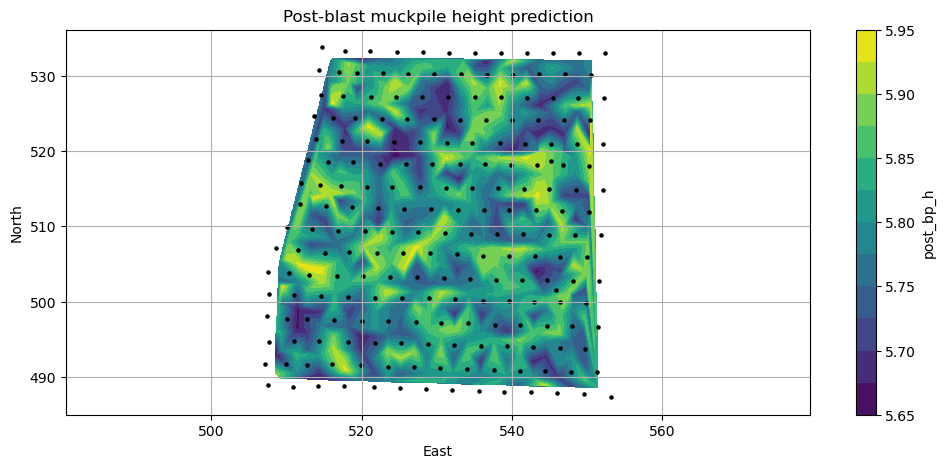

In [55]:
plot_contour(df_cleaned, bp, 'post_bp_h', 'Post-blast height')

It would seem that this blast results in some substantial swelling in some locations, due to the pronounced vertical movement. This acutally occurs in a real-life environment, so the model work surprisingly well so far.

However, a change in the random seed number would lead to a different outcome, so multiple simulations are advisory.

Now, let's see the pre- and post- blast monitors from a 2D top view to see how the model performed.

In [56]:
df_pre = df[['east', 'north', 'elev', 'bp_elev']].copy()
df_post = df[['post_east', 'post_north', 'post_elev', 'post_bp_elev']].copy()

In [57]:
df_pre.head()

,east,north,elev,bp_elev
0,514.871527,504.410179,453.98,454.188434
1,540.312310,528.172594,453.23,454.945075
2,538.137515,517.138074,451.69,454.918343
3,517.997580,492.521779,453.35,454.933214
4,515.226490,510.620756,450.99,454.152681


In [58]:
df_post.columns = df_pre.columns.to_list()
df_post.head()

,east,north,elev,bp_elev
0,513.394726,504.497695,454.372664,455.933221
1,538.870416,527.606103,453.509127,455.874693
2,536.852718,516.684958,451.731130,455.754186
3,516.672081,492.570425,453.644177,455.883846
4,514.380156,510.152235,450.918335,455.699097


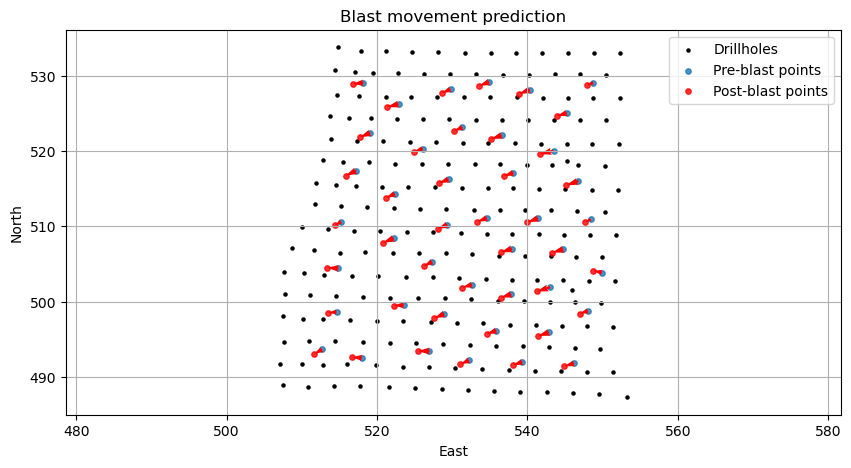

In [59]:
plt.figure(figsize=(10, 5))

plt.scatter(bp['east'], bp['north'], c='black', s=5, label='Drillholes')

plt.scatter(df_pre['east'], df_pre['north'], color='tab:blue', label='Pre-blast points', alpha=0.8, s=15)

# Plot post-blast points
plt.scatter(df_post['east'], df_post['north'], color='red', label='Post-blast points', alpha=0.8, s=15)

# Plot arrows
for i in df_pre.index.tolist():
    plt.quiver(
        df_pre['east'][i], df_pre['north'][i],
        df_post['east'][i] - df_pre['east'][i], df_post['north'][i] - df_pre['north'][i],
        angles='xy', scale_units='xy', scale=1, color='red', width=0.003
    )

plt.xlabel('East')
plt.ylabel('North')
plt.title('Blast movement prediction')
plt.legend(loc='best')
plt.grid(True)
plt.axis('equal')
plt.show()

The result looks very realistic! It even catches a random movement vector going in a totally different direction from the expected!

In this case movement is relatively low due to the very low powder factor used (around 0.3 kg/m³) and the conditions taking place in weak rock. The purpsoe of the blast in this case is to make the rock mass diggable and hence, very little movement occurs.

However, once more, multiple simulations are advisory.

Last but not least, let's try to plot pre- and post- blast movement locations with the post-blast surface on a 3D plot to evaluate the result.

The plot is interactive, just give it a while to load.

In [60]:
# Pre-blast selected monitors scatter plot
scatter_pre = go.Scatter3d(
    x=df_pre['east'],
    y=df_pre['north'],
    z=df_pre['elev'],
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.8),
    name='Pre-blast points'
)

In [61]:
# Post-blast selected monitors scatter plot
scatter_post = go.Scatter3d(
    x=df_post['east'],
    y=df_post['north'],
    z=df_post['elev'],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8),
    name='Post-blast points'
)

In [62]:
# Create a grid for the pre-blast surface plot
east_grid_pre = np.linspace(df_cleaned['post_east'].min(), df_cleaned['post_east'].max(), 500)
north_grid_pre = np.linspace(df_cleaned['post_north'].min(), df_cleaned['post_north'].max(), 500)
east_mesh_pre, north_mesh_pre = np.meshgrid(east_grid_pre, north_grid_pre)

# Interpolate 'bp_elev' values onto the grid
from scipy.interpolate import griddata
bp_elev_grid_pre = griddata(
    (df_cleaned['east'], df_cleaned['north']),
    df_cleaned['bp_elev'],
    (east_mesh_pre, north_mesh_pre),
    method='linear'
)

# Handle missing values in the grid
# bp_elev_grid_pre = np.nan_to_num(bp_elev_grid_pre, nan=np.min(df_cleaned['bp_elev']))
bp_elev_grid_pre = np.nan_to_num(bp_elev_grid_pre, nan=target_elevation)

# Surface plot
surface_pre = go.Surface(
    x=east_mesh_pre,
    y=north_mesh_pre,
    z=bp_elev_grid_pre,
    colorscale='Viridis',
    opacity=0.4,
    name='Pre-blast Surface'
)

In [63]:
# Create a grid for the post-blast surface plot
east_grid_post = np.linspace(df_cleaned['post_east'].min(), df_cleaned['post_east'].max(), 500)
north_grid_post = np.linspace(df_cleaned['post_north'].min(), df_cleaned['post_north'].max(), 500)
east_mesh_post, north_mesh_post = np.meshgrid(east_grid_post, north_grid_post)

# Interpolate 'bp_elev' values onto the grid
from scipy.interpolate import griddata
bp_elev_grid_post = griddata(
    (df_cleaned['post_east'], df_cleaned['post_north']),
    df_cleaned['post_bp_elev'],
    (east_mesh_post, north_mesh_post),
    method='linear'
)

# Handle missing values in the grid
bp_elev_grid_post = np.nan_to_num(bp_elev_grid_post, nan=np.min(df_cleaned['post_bp_elev']))

# Surface plot
surface_post = go.Surface(
    x=east_mesh_post,
    y=north_mesh_post,
    z=bp_elev_grid_post,  # Use the scaled values
    colorscale='Viridis',
    opacity=0.8,
    name='Post-blast Surface'
)

In [64]:
# Combine scatter and surface plots
fig = go.Figure(data=[
    scatter_pre,
    scatter_post,
    surface_post,
    surface_pre.update(showscale=False)
]
               )

# Calculate ranges for x, y, z
x_range = df_cleaned['east'].max() - df_cleaned['east'].min()
y_range = df_cleaned['north'].max() - df_cleaned['north'].min()
z_range = max(df_cleaned['post_elev'].max() + 0.5, df_cleaned['post_bp_elev'].max() + 0.5) - min(target_elevation, df_cleaned['bp_elev'].min())

# Find the maximum range to unify scaling
max_range = max(x_range, y_range, z_range)

# Center all axes to the same scale
x_mid = (df_cleaned['east'].max() + df_cleaned['east'].min()) / 2
y_mid = (df_cleaned['north'].max() + df_cleaned['north'].min()) / 2
z_mid = (min(target_elevation, df_cleaned['bp_elev'].min()) + max(df_cleaned['post_elev'].max() + 0.5, df_cleaned['post_bp_elev'].max() + 0.5)) / 2

fig.update_layout(
    scene=dict(
        xaxis=dict(title='East', range=[x_mid - max_range / 2, x_mid + max_range / 2]),
        yaxis=dict(title='North', range=[y_mid - max_range / 2, y_mid + max_range / 2]),
        zaxis=dict(title='Elevation', range=[z_mid - max_range / 2, z_mid + max_range / 2]),
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    legend=dict(x=0.8, y=0.9, title=dict(text="Legend")), 
    title="3D Scatter and Surface Plot",
    width=1000,
    height=800 
)

pio.write_html(fig, file='blast_movement_demo_realization.html', auto_open=True)

The plot definitely shows how a blast movement outcome looks like. However, the highest blast panel height values occur in places where the simulated monitor is placed higher. Hence, the full potential monitoring locations dataframe is more suitable for simulating the post-blast panel shape.

In [65]:
import gstools as gs
from scipy.spatial.distance import pdist, squareform

def get_variogram(df, target, bins, max_fit_range):   
    '''
    Plot variogram model of simulated blast movement results
    '''
    coords_array = df[['post_east', 'post_north', 'post_elev']].values  # Shape (n_points, 3)
    target_values = df[target].values  # Shape (n_points,)
    
    # Convert coordinates to a tuple of arrays (x, y, z)
    coords = tuple(coords_array[:, i] for i in range(coords_array.shape[1]))
    
    # Validate the shapes
    assert len(coords[0]) == len(target_values), "Mismatch between coordinates and values!"
    
    # Compute the experimental variogram
    bin_edges = np.linspace(0, np.percentile(squareform(pdist(coords_array)), 95), num=bins)
    variogram = gs.vario_estimate(coords, target_values, bin_edges=bin_edges)
    
    # Subset the experimental variogram data up to the max range
    fit_indices = variogram[0] <= max_fit_range
    fit_lags = variogram[0][fit_indices]
    fit_sems = variogram[1][fit_indices]
    
    # Define a theoretical variogram model (e.g., spherical with anisotropy)
    model = gs.Gaussian(dim=3)
    
    # Fit the model to the subsetted variogram data
    model.fit_variogram(fit_lags, fit_sems)
    
    # Plot the experimental variogram and the fitted model
    plt.figure(figsize=(8, 5))
    plt.scatter(variogram[0], variogram[1], color="blue", label="Experimental Variogram")
    plt.plot(
        np.linspace(0, max_fit_range, 100),
        model.variogram(np.linspace(0, max_fit_range, 100)),
        color="red",
        label=f"Fitted Gaussian Model (up to range {max_fit_range})",
    )
    plt.axhline(target_values.var(), color="green", linestyle="--", label="Sill")
    plt.xlabel("Lag Distance")
    plt.ylabel(f"Semivariance ({target})")
    plt.title(f"Semivariogram of {target}")
    plt.legend()
    plt.grid(True)
    plt.show()

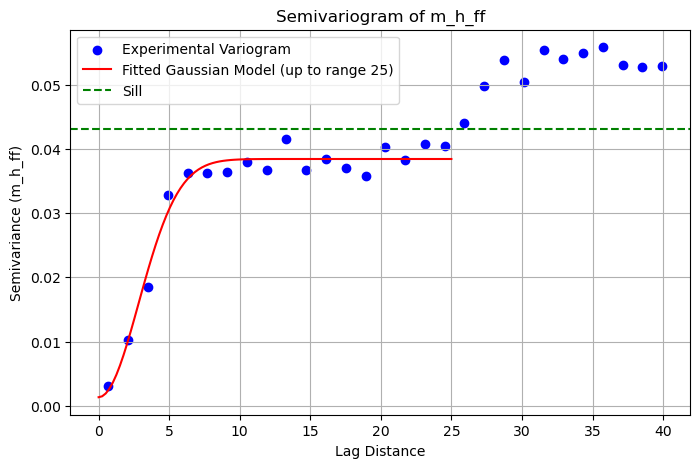

In [66]:
get_variogram(df_cleaned, 'm_h_ff', bins=30, max_fit_range=25)

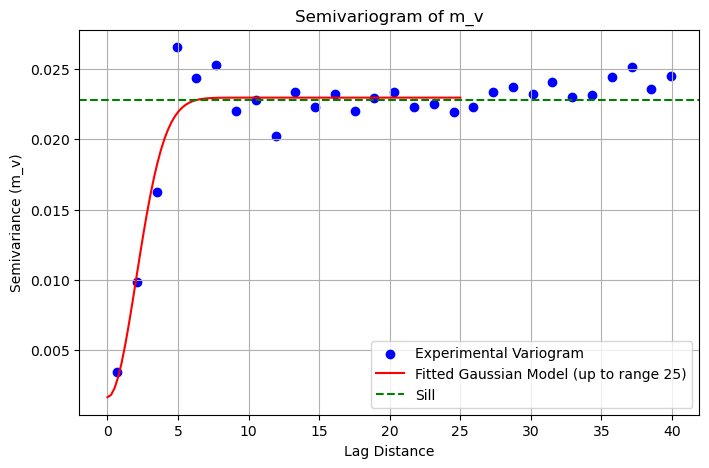

In [67]:
get_variogram(df_cleaned, 'm_v', bins=30, max_fit_range=25)

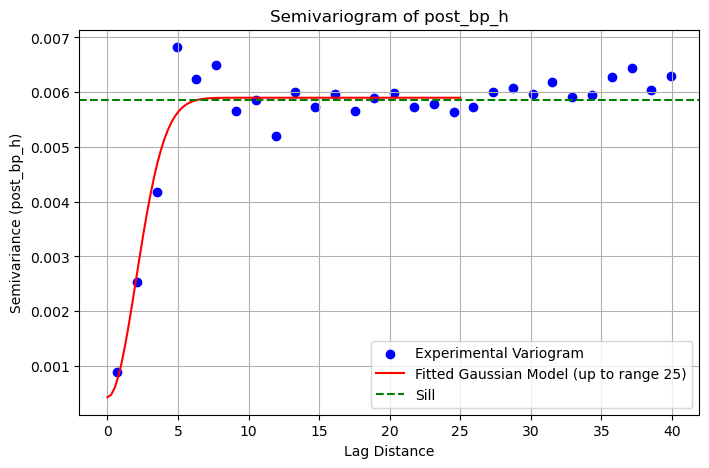

In [68]:
get_variogram(df_cleaned, 'post_bp_h', bins=30, max_fit_range=25)

## Conclusions and future work

The use of a linear model could be evident throughout the near-parallel movement in different locations. However, this could be due to the presense of an autocorrelation between movement vectors for a single blast panel. So far no physical observations in such close proximity exist due to the interference between the radio signals between the actual monitors, as actual monitors need to be placed 25-30 m apart from each other.

Regardless, this model provides a good foundation for future calibration and simulating different scenarios for estimating the influence of different parameters on the final result with relative ease, compared to physics-based simulators. Hence, ML-based models for a certain mining site for the sake of modelling blast movement is a viable and computationally efficient strategy.